In [1]:
from itertools import combinations
import pathlib
from typing import Dict, List
import warnings
import yaml

import lightgbm as lgb
import matplotlib.pyplot as plt
from numba import njit, prange
import numpy as np
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import re
from sklearn.model_selection import GroupKFold


warnings.simplefilter('ignore')

/home/ss/miniconda3/envs/optiver/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def train_using_cv(
        dataset: pd.DataFrame,
        kfold_params: Dict,
        outputs_dir: pathlib.Path,
    ):
    
    kfold = GroupKFold(**kfold_params)
    target_columns = ['target']
    feature_columns = [
        col for col in dataset.columns
        if col not in ['date_id', 'target', 'time_id', 'row_id']
    ]
    groups = dataset['stock_id']
    oof_true = []
    oof_pred = []
    fimps = []
    best_param_records = {}
    best_value_records = {}
    history = {
        'train_mae': [],
        'valid_mae': [],
    }
    for k, (train_indices, valid_indices) in enumerate(kfold.split(dataset, groups=groups)):
        print(f'fold {k+1}')

        train_X = dataset.iloc[train_indices][feature_columns]
        train_y = dataset.iloc[train_indices][target_columns].values.reshape(-1)
        valid_X = dataset.iloc[valid_indices][feature_columns]
        valid_y = dataset.iloc[valid_indices][target_columns].values.reshape(-1)
        if 'weight' in train_X.columns:
            train_w = train_X['weight']
            train_X = train_X.drop('weight', axis=1)
        else:
            train_w = None
        if 'weight' in valid_X.columns:
            valid_w = valid_X['weight']
            valid_X = valid_X.drop('weight', axis=1)
        else:
            valid_w = None
        print(train_X.shape, train_y.shape, train_w.shape if train_w is not None else None)
        print(valid_X.shape, valid_y.shape, valid_w.shape if valid_w is not None else None)
        
        best_param_records[f'fold{k+1}'] = {}
        best_value_records[f'fold{k+1}'] = {}

        objective = Objective(train_X, train_y, train_w, valid_X, valid_y, valid_w)
        study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))
        optuna.logging.set_verbosity(optuna.logging.WARNING)
        study.optimize(objective, n_trials=2)
        best_params = study.best_params
        add_params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'mae',
            'metric': 'mae',
            'seed': 42,
        }
        best_params.update(add_params)

        [print(f'{k}: {v}') for k, v in best_params.items()]
        print(f'best value: {study.best_value}')

        best_param_records[f'fold{k+1}'] = best_params
        best_value_records[f'fold{k+1}'] = study.best_value
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(100),
        ]
        
        train_dataset = lgb.Dataset(train_X, train_y, weight=train_w)
        valid_dataset = lgb.Dataset(valid_X, valid_y)
        
        model = lgb.train(
            params=best_params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=3000,
            categorical_feature=['imbalance_buy_sell_flag'],
        )
        model.save_model(
            outputs_dir.joinpath(f'lightgbm_optuna_group_fold{k+1}'),
            num_iteration=model.best_iteration
        )

        fimp = model.feature_importance(importance_type='gain')
        fimp = pd.DataFrame(fimp, index=valid_X.columns, columns=[f'fold{k+1}'])
        fimps.append(fimp)
        
        oof_true.append(valid_y)
        oof_pred.append(model.predict(valid_X))

        history['train_mae'].append(np.mean(abs(train_y - model.predict(train_X, num_iteration=model.best_iteration))))
        history['valid_mae'].append(np.mean(abs(valid_y - model.predict(valid_X, num_iteration=model.best_iteration))))
    
    fimps = pd.concat(fimps, axis=1)
    mean_fimps = fimps.mean(axis=1)
    std_fimps = fimps.std(axis=1)
    fimps['mean_fimps'] = mean_fimps
    fimps['std_fimps'] = std_fimps
    fimps.sort_values(by='mean_fimps', inplace=True)
    display(fimps)
    
    fimps['mean_fimps'].plot(kind='barh', xerr=fimps['std_fimps'], capsize=3)
    plt.show()
    
    oof_true = np.concatenate(oof_true)
    oof_pred = np.concatenate(oof_pred)
    oof_mae = np.mean(abs(oof_true - oof_pred))
    print(f'oof mae: {oof_mae:.4f}')

    _, ax = plt.subplots()
    bins = np.linspace(-20, 20, 100)
    ax.hist(oof_true, bins=bins, histtype='step')
    ax.hist(oof_pred, bins=bins, histtype='step')
    plt.show()
    
    with open(outputs_dir.joinpath('result_lightgbm_optuna.yaml'), 'w') as f:
        yaml.dump(
            {
                'best_param_records': best_param_records,
                'best_value_records': best_value_records,
                'oof rmse': oof_mae.item(),
            },
            f,
            default_flow_style=False
        )
    return pd.DataFrame.from_dict(history)


class Objective:
    def __init__(self, train_X, train_y, train_w, valid_X, valid_y, valid_w):
        self.train_X = train_X
        self.train_y = train_y
        self.train_w = train_w
        self.valid_X = valid_X
        self.valid_y = valid_y
        self.valid_w = valid_w

    def __call__(self, trial):
        params = {
            'task': 'train',
            'boosting_type': 'gbdt',
            'objective': 'mae',
            'metric': 'mae',
            'learning_rate': trial.suggest_float('learning_rate', 1e-03, 1e-01),
            'seed': 42,
            'max_depth':  trial.suggest_int('max_depth', 3, 10),
            #'num_leaves': trial.suggest_int('max_depth', 31, 127),
            #'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
            #'feature_fraction': trial.suggest_float('feature_fraction', 0.2, 1.0),
            #'feature_fraction_bynode': trial.suggest_float('feature_fraction_bynode', 0.2, 1.0),
            #'lambda_l2': trial.suggest_float('lambda_l2', 0.1, 10),
            'verbose': -1,
        }
        
        callbacks = [
            lgb.early_stopping(stopping_rounds=100, verbose=True),
            lgb.log_evaluation(0),
        ]
        train_dataset = lgb.Dataset(self.train_X, self.train_y, weight=self.train_w)
        valid_dataset = lgb.Dataset(self.valid_X, self.valid_y)
        model = lgb.train(
            params=params,
            train_set=train_dataset,
            valid_sets=[train_dataset, valid_dataset],
            valid_names=['train', 'valid'],
            callbacks=callbacks,
            num_boost_round=3000,
            categorical_feature=['imbalance_buy_sell_flag'],
        )

        preds = model.predict(self.valid_X)
        mae = np.mean(abs(preds - self.valid_y))
        return mae

In [4]:
@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))

    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            if mid_val == min_val:  # Prevent division by zero
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features


def calculate_triplet_imbalance_numba(price, df):
    # Convert DataFrame to numpy array for Numba compatibility
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]

    # Calculate the triplet imbalance
    features_array = compute_triplet_imbalance(df_values, comb_indices)

    # Create a DataFrame from the results
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)

    return features


def preprocess(df_):
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    df_.eval('diff_ask_bid_price = ask_price - bid_price', inplace=True)
    df_.eval('sum_ask_bid_price = ask_price + bid_price', inplace=True)
    df_.eval('diff_ask_bid_size = ask_size - bid_size', inplace=True)
    df_.eval('sum_ask_bid_size = ask_size + bid_size', inplace=True)
    df_.eval('imbalance_buy_sell_flag = imbalance_buy_sell_flag + 1', inplace=True)
    df_.eval('mean_ask_bid_price = (ask_price + bid_price) / 2', inplace=True)
    df_.eval('liquidity_imbalance = (bid_size - ask_size) / (bid_size + ask_size)', inplace=True)
    df_.eval('matched_imbalance = (imbalance_size - matched_size) / (matched_size + imbalance_size)', inplace=True)
    df_.eval('size_imbalance = bid_size / ask_size', inplace=True)
    for c in combinations(prices, 2):
        df_.eval(f'{c[0]}_{c[1]}_imb = ({c[0]} - {c[1]}) / ({c[0]} + {c[1]})', inplace=True)

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df_)
        df_[triplet_feature.columns] = triplet_feature.values
    # df_['weight'] = (
    #     df_[['stock_id', 'target']]
    #     .groupby('stock_id')
    #     .transform(lambda x: abs((x - x.quantile(0.50))))
    # )

In [5]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_ez_df = pd.read_csv(outputs_dir_path.joinpath('train_ez.csv'))
train_ez_df = train_ez_df.dropna(subset=['target'])
preprocess(train_ez_df)
display(train_ez_df)

train_not_ez_df = pd.read_csv(outputs_dir_path.joinpath('train_not_ez.csv'))
train_not_ez_df = train_not_ez_df.dropna(subset=['target'])
preprocess(train_not_ez_df)
display(train_not_ez_df)

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,ask_price_wap_imb,bid_price_wap_imb,ask_price_bid_price_wap_imb2,ask_price_bid_price_reference_price_imb2,ask_price_wap_reference_price_imb2,bid_price_wap_reference_price_imb2,matched_size_bid_size_ask_size_imb2,matched_size_bid_size_imbalance_size_imb2,matched_size_ask_size_imbalance_size_imb2,bid_size_ask_size_imbalance_size_imb2
0,0,0,0,3180602.69,2,0.999812,13380276.64,NaN,NaN,0.999812,...,0.000013,-9.400884e-05,0.138298,-1.927541e+12,1.382979e-01,-1.693353e+12,255.368402,3.269177,3.215423,59.816770
1,3,0,0,11917682.27,0,1.000171,18389745.62,NaN,NaN,0.999999,...,0.000107,-5.000003e-07,214.000000,2.500000e-01,2.514620e-01,1.710000e+02,37.571704,0.543170,0.565807,23.995112
2,4,0,0,447549.96,0,0.999532,17860614.95,NaN,NaN,0.999394,...,0.000008,-3.030918e-04,0.026403,3.507246e+00,3.418803e-02,3.391304e+00,1111.684024,40.395505,38.945308,26.855187
3,9,0,0,3039700.65,0,1.000969,6248958.45,NaN,NaN,0.999354,...,0.000323,-3.231044e-04,1.000000,2.500000e-01,5.000000e-01,1.500000e+00,780344.931250,1.057936,1.057938,379187.706250
4,10,0,0,10482752.19,0,1.001374,8839457.10,NaN,NaN,0.999885,...,0.000660,-5.750331e-05,11.486957,3.690808e-02,4.012112e-02,1.194783e+01,43.482181,0.186301,0.190585,51.769247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2642164,192,480,540,67162.62,2,1.000762,11790079.43,1.000834,1.000762,1.000545,...,0.000032,-7.645248e-05,0.418301,0.000000e+00,0.000000e+00,4.183007e-01,117.901047,114.781620,4375.051488,36.795736
2642165,193,480,540,6500948.04,2,1.001599,80357531.06,1.002908,1.002326,1.001454,...,0.000034,-3.844262e-05,0.883117,-3.062684e-12,6.530724e-12,8.831169e-01,1611.466562,12.131889,12.033825,122.713997
2642166,195,480,540,2440722.89,0,1.000317,28280361.74,0.999734,0.999734,1.000317,...,0.000053,-5.498227e-06,9.636364,5.269212e+11,9.636364e+00,NaN,97.218283,10.728671,12.183564,7.374204
2642167,196,480,540,349510.47,0,1.000643,9187699.11,1.000129,1.000386,1.000643,...,0.000040,-8.793572e-05,0.460227,NaN,4.602273e-01,7.926335e+11,80.406071,61.205415,34.508349,1.292590


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,ask_price_wap_imb,bid_price_wap_imb,ask_price_bid_price_wap_imb2,ask_price_bid_price_reference_price_imb2,ask_price_wap_reference_price_imb2,bid_price_wap_reference_price_imb2,matched_size_bid_size_ask_size_imb2,matched_size_bid_size_imbalance_size_imb2,matched_size_ask_size_imbalance_size_imb2,bid_size_ask_size_imbalance_size_imb2
0,1,0,0,166603.91,0,0.999896,1.642214e+06,NaN,NaN,0.999896,...,0.000330,-0.000052,6.346154,-6.881500e+12,6.346154e+00,9.367487e+11,93.345872,9.032273,10.107002,8.404237
1,2,0,0,302879.87,0,0.999561,1.819368e+06,NaN,NaN,0.999403,...,0.000149,-0.000299,0.499162,4.664557e+00,6.788155e-01,2.778481e+00,93.951375,5.724241,5.341913,13.972041
2,5,0,0,0.00,1,1.000635,1.355288e+07,NaN,NaN,0.999779,...,0.000317,-0.000111,2.873303,0.000000e+00,0.000000e+00,2.873303e+00,3676.386870,6904.149955,2398.737222,1.877461
3,6,0,0,969969.40,2,1.000115,3.647504e+06,NaN,NaN,0.999506,...,0.000141,-0.000247,0.572874,2.758621e-01,1.460870e+00,2.327935e-01,1276.287849,2.779526,2.771319,337.684647
4,7,0,0,9412959.10,2,0.999818,2.126125e+07,NaN,NaN,0.999741,...,0.000065,-0.000130,0.501931,4.051948e+00,7.142857e-01,2.363636e+00,8275.366608,1.259408,1.259065,3662.625516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595718,190,480,540,466320.15,0,0.999295,3.929472e+07,0.998983,0.999139,0.999295,...,0.000070,-0.000008,8.750000,1.405123e+12,8.750000e+00,1.441152e+11,261.921159,86.943330,130.640787,1.989666
2595719,191,480,540,36937785.44,2,0.995983,6.083261e+08,0.999086,0.997746,0.995913,...,0.000013,-0.000023,0.555556,0.000000e+00,-8.881784e-12,5.555556e-01,16564.759241,15.504510,15.489077,1003.650465
2595720,194,480,540,262271.52,0,1.001504,3.922295e+06,1.000677,1.000677,1.001504,...,0.000180,-0.000026,6.792453,9.299933e+11,6.792453e+00,-2.386908e+11,31.838333,15.158999,29.845092,1.032201
2595721,197,480,540,0.00,1,0.995789,1.272544e+07,0.995789,0.995789,0.995789,...,0.000043,-0.000004,10.750000,-2.822256e+11,1.075000e+01,NaN,76.848867,756.887784,69.681820,9.722528


fold 1


[I 2023-10-25 10:32:40,027] A new study created in memory with name: no-name-8d494a1c-44fc-419d-ab53-a29546e8b7a8


(2113069, 44) (2113069,) None
(529100, 44) (529100,) None
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[845]	train's l1: 4.71861	valid's l1: 4.67562
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[358]	train's l1: 4.72684	valid's l1: 4.67566
learning_rate: 0.03807947176588889
max_depth: 10
task: train
boosting_type: gbdt
objective: mae
metric: mae
seed: 42
best value: 4.675619459687062
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10595
[LightGBM] [Info] Number of data points in the tr

,fold1,fold2,fold3,fold4,fold5,mean_fimps,std_fimps
mean_ask_bid_price,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
far_price_wap_imb,3804.919959,5038.451099,3655.709595,1622.198361,2301.845577,3284.624918,1342.929106
far_price_bid_price_imb,4650.795848,4773.129016,5014.824971,1905.260576,3010.947957,3870.991674,1354.074858
reference_price_far_price_imb,5151.570276,6161.436629,4872.700754,2342.664077,2703.571239,4246.388595,1649.506154
far_price_ask_price_imb,5624.659033,5487.849634,5907.455546,1825.565331,3002.055297,4369.516968,1839.357631
bid_price_wap_reference_price_imb2,4916.325156,6309.909732,6476.298398,2894.748910,3870.652345,4893.586908,1545.413496
diff_ask_bid_size,4971.409442,10933.059901,5410.924734,1843.133729,2218.084759,5075.322513,3641.681137
bid_size_ask_size_imbalance_size_imb2,5248.419978,7144.736194,6791.647606,2581.568042,3803.995393,5114.073442,1942.021072
reference_price_near_price_imb,6868.584064,6890.943499,8361.413136,3160.922587,4747.830788,6005.938815,2046.497162
ask_price_wap_reference_price_imb2,7704.242008,8143.301938,9640.228968,4934.903486,6004.680417,7285.471363,1845.380741


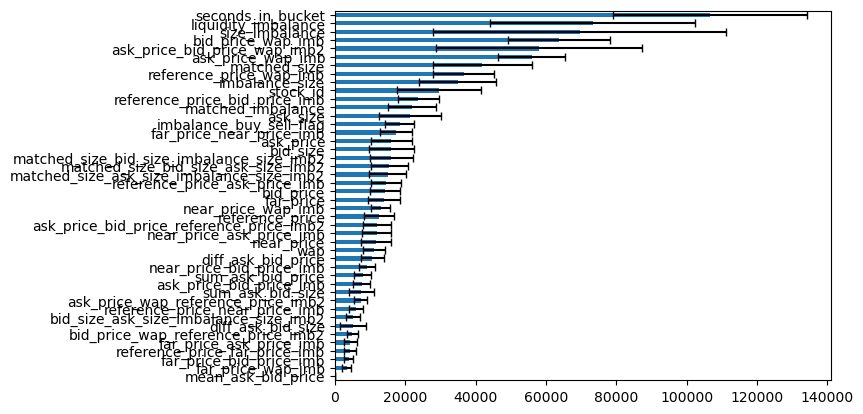

oof mae: 4.7464


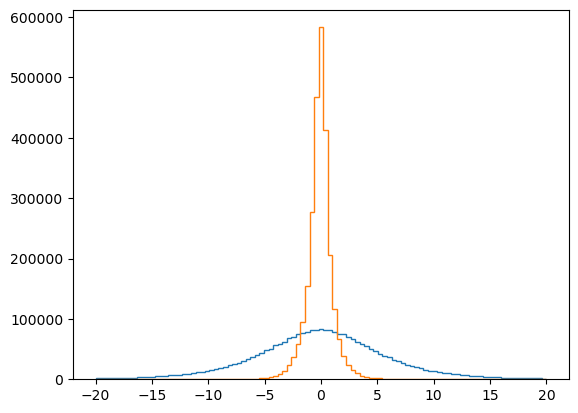

In [6]:
kfold_params = {
    'n_splits': 5,
}

history_ez = train_using_cv(
    kfold_params=kfold_params,
    dataset=train_ez_df,
    outputs_dir=outputs_dir_path,
)

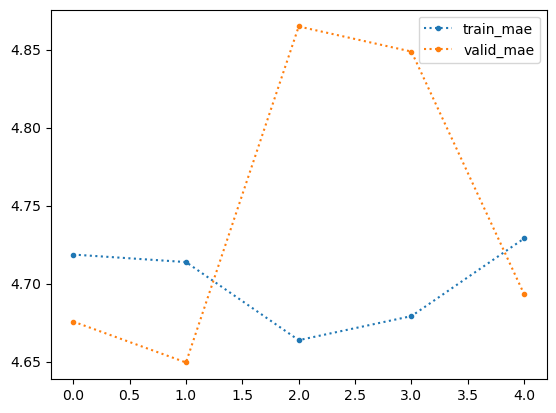

In [7]:
history_ez.plot(marker='.', linestyle=':')
plt.show()